# GW150914 with MCMC Infinity

Example of using `mcmc_infinity` to sample GW150914.

**Important:** the initial sampling (step 1) is run in a separate script.

In [1]:
# Use autoreload magic
%load_ext autoreload
%autoreload 2

import bilby
import mcmc_infinity as mc
import corner
import matplotlib.pyplot as plt
import jax
import numpy as np
from scipy.optimize import minimize

import os
os.environ["OMP_NUM_THREADS"] = "1"

seed = 1234

# Initial samples

Load the initial samples from the bilby result and fetch the parameters we're going to sample.

We scale the geocent time such that the values are of order 1 rather than $10^9$.

In [2]:
result = bilby.core.result.read_in_result("outdir/GW150914_nessai_result.json")
parameters = [
    "chirp_mass",
    "mass_ratio",
    "chi_1",
    "chi_2",
    "ra",
    "dec",
    "theta_jn",
    "psi",
    "geocent_time",
]
# Extract the initial samples from the result
initial_samples = result.posterior[parameters].to_numpy()
geocent_idx = parameters.index("geocent_time")
geocent_min = initial_samples[:, geocent_idx].min()
initial_samples[:, geocent_idx] = initial_samples[:, geocent_idx] - geocent_min

In [3]:
len(initial_samples)

4856

# Proposal

First, we train the normalizing flow using the initial samples.

 23%|██▎       | 113/500 [00:14<00:51,  7.54it/s, train=4.81, val=5.57 (Max patience reached)]


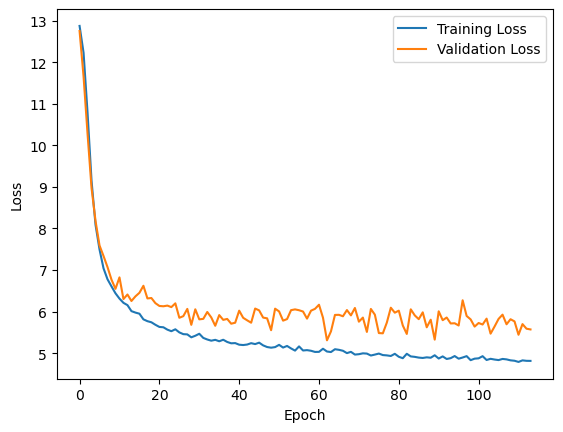

In [4]:
dim = len(parameters)
bounds = []
for p in parameters:
    bounds.append(np.array([result.priors[p].minimum, result.priors[p].maximum]))

bounds[geocent_idx] = bounds[geocent_idx] - geocent_min

flow_key, fit_key, samples_key = jax.random.split(jax.random.key(seed), 3)
nf_proposal = mc.normalizing_flow_proposal.NormalizingFlowProposal(
   dim, bounds=bounds, key=flow_key, flow_layers=6, nn_width=32, nn_depth=3,
)

init_key = jax.random.key(seed + 10)

losses = nf_proposal.fit(
    initial_samples,
    key=fit_key,
    max_epochs=500,
    batch_size=100,
    max_patience=50,
    learning_rate=0.001,
)

# Plot the loss
fig = plt.figure()
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Plot the samples from the flow compared to the initial samples.

We plot the samples with different 'inflation' parameters.

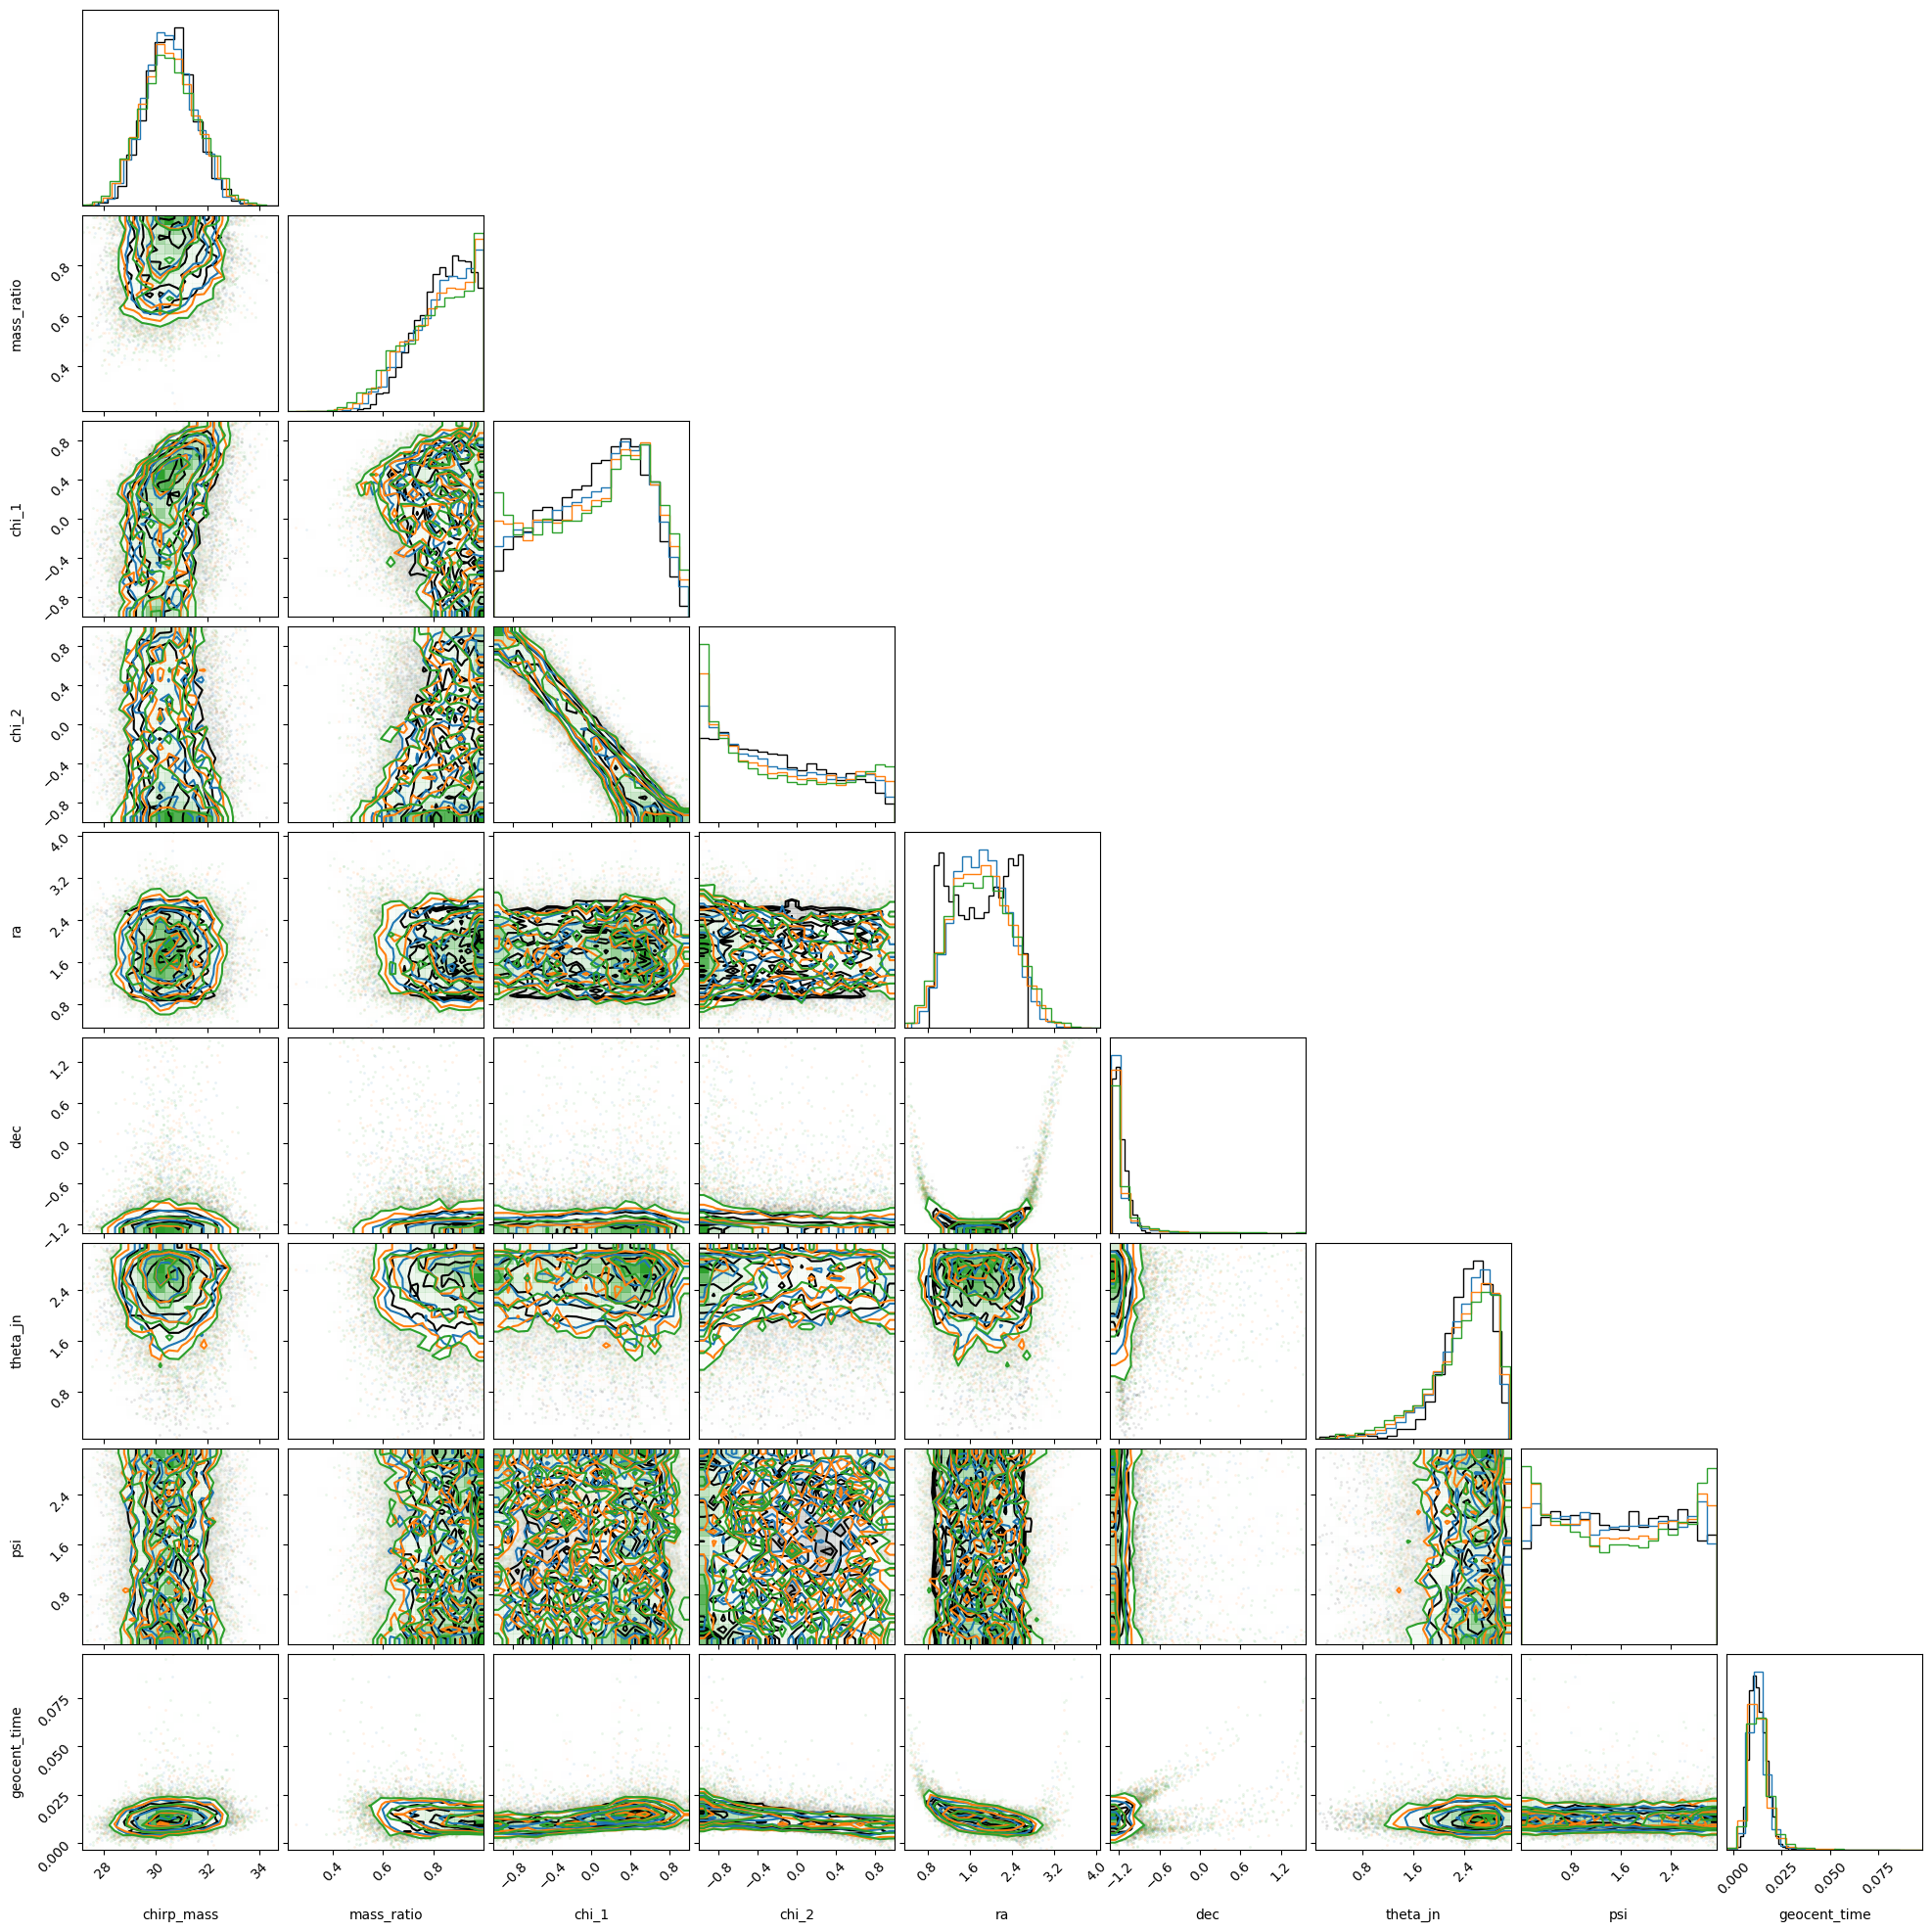

In [5]:

fig = corner.corner(
    initial_samples,
    density=True,
    hist_kwargs={"density": True, "color": "k"},
)

for i, sigma in enumerate([1, 1.1, 1.2]):
    nf_proposal.set_inflation_scale(sigma)
    flow_samples = nf_proposal.sample(samples_key, num_samples=5000)

    fig = corner.corner(
        np.array(flow_samples),
        labels=parameters,
        fig=fig,
        density=True,
        color=f"C{i}",
        hist_kwargs={"density": True, "color": f"C{i}"},
    )
# Reset the flow annealing to 1.0
nf_proposal.set_inflation_scale(1.0)

We then define a mixture proposal that includes the normalizing flow and uniform
proposal.

Below we construct the proposal and plot samples drawn from it.

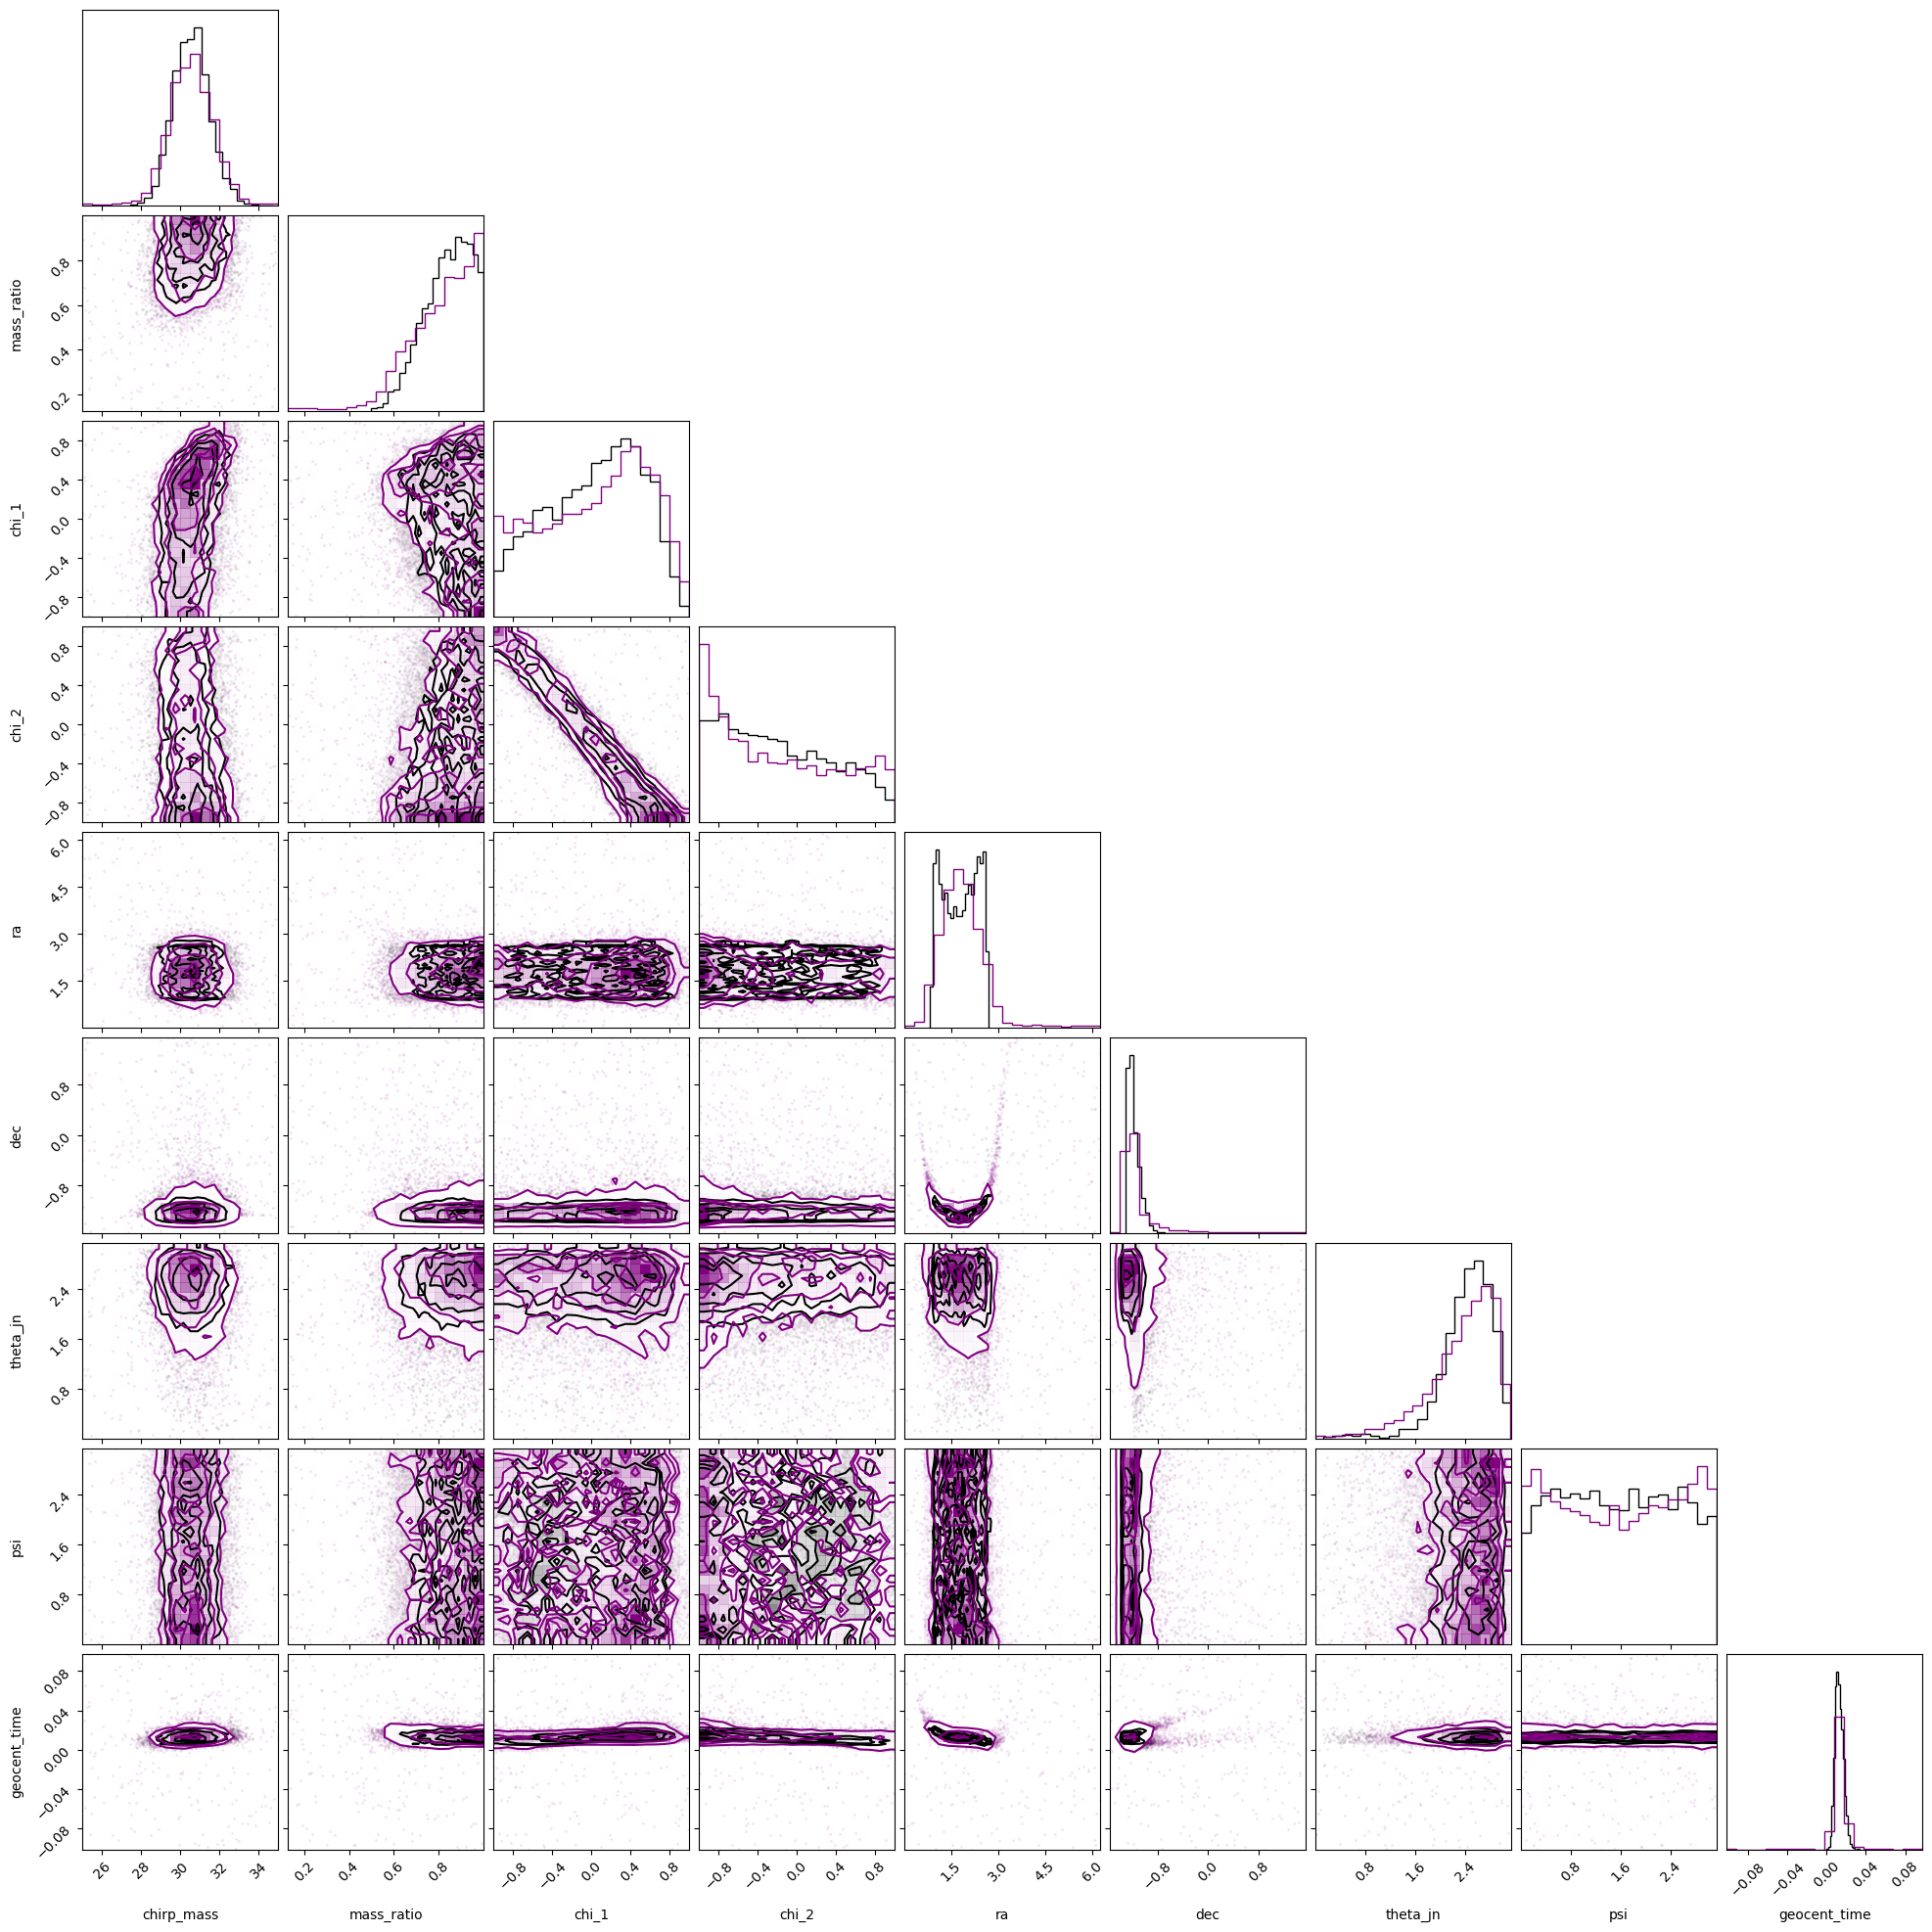

In [6]:

uniform_proposal = mc.uniform_proposal.UniformProposal(
    dim, bounds=bounds,
)
nf_proposal.set_inflation_scale(1.1)
proposal = mc.mixture_proposal.MixtureProposal(
    nf_proposal, 
    uniform_proposal,
    weights=[0.95, 0.05],  # Adjust the weights as needed
)

fig = corner.corner(
    initial_samples,
    density=True,
    hist_kwargs={"density": True, "color": "k"},
)

proposal_samples = proposal.sample(samples_key, num_samples=5000)
proposal_samples = proposal_samples[np.isfinite(proposal_samples).all(axis=1)]

fig = corner.corner(
    np.array(proposal_samples),
    labels=parameters,
    fig=fig,
    density=True,
    color="purple",
    hist_kwargs={"density": True, "color": "purple"},
)

# Define the target

We fetch the the likelihood and priors from the script used to produce the initial samples. This ensures we're using the exact same data and likelihood.

In [ ]:
from run_GW150914 import likelihood, priors

# Make sure the likelihood and priors are set up correctly
likelihood.parameters
theta = priors.sample()
likelihood.parameters.update(theta)
likelihood.log_likelihood()

/home/michael/.conda/envs/perfect-mcmc/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
08:56 bilby INFO    : Downloading analysis data for ifo H1
08:56 bilby INFO    : Downloading psd data for ifo H1


Define a class for the target function. When called, this should return the unnormalized posterior probability.

In [ ]:
class BilbyTarget:

    def __init__(self, likelihood, priors, parameters):
        self.likelihood = likelihood
        self.priors = priors
        self.dim = len(parameters)
        self.parameters = parameters

    def logP(self, x):
        if x.ndim > 1:
            if x.shape[0] == 1:
                x = x[0]
            else:
                raise ValueError("Input x should be a 1D array or a single sample.")

        theta = {k: v for k, v in zip(self.parameters, x)}
        theta["geocent_time"] += geocent_min
        log_prior = self.priors.ln_prob(theta)
        if not np.isfinite(log_prior):
            return -np.inf
        self.likelihood.parameters.update(theta)
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

    def __call__(self, *args, **kwds):
        return self.logP(*args, **kwds)

In [ ]:
target = BilbyTarget(likelihood, priors, parameters)

Check the target is working

In [ ]:
x = proposal.sample(jax.random.key(seed + 20))
target(x)

np.float64(-4964.268823822666)

# Finding the global maximum (Step 3)

Get the initial sample, for now we use the maximum log-likelihood from the posterior.

In this example, we Nelder-Mead as implemented in scipy.

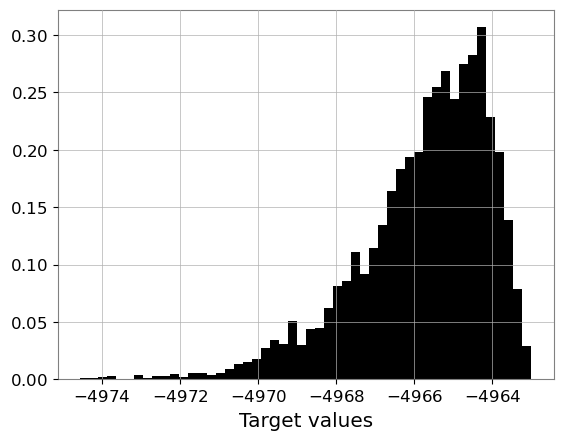

KeyboardInterrupt: 

In [ ]:
def func(x):
    # Make the function is always finite
    return np.nan_to_num(target(x)) - proposal(x).item()

initial_target_values = np.array([target(x) for x in initial_samples])

fig = plt.figure()
plt.hist(initial_target_values, bins=50, density=True)
plt.xlabel("Target values")
plt.show()


In [ ]:

min_result = minimize(
    func,
    initial_samples[np.argmax(initial_target_values)],
    method="Nelder-Mead",
)
print("Minimum found at:", min_result.x)

# Initialize the sampler

In [ ]:
x0 = [min_result.x]
sampler = mc.sampler.PerfectSampler(target, proposal, x0, seed=seed)

# Drawing perfect samples

We draw a single sample to determine our initial value for `T`

In [ ]:
test_sample, t_test = sampler.get_perfect_sample(2, verbose=True, return_T=True)

Trying T=2 steps...


Draw a full set of samples

In [ ]:

T, num_samples = 2, 100

samples, t_vals = sampler.get_perfect_samples(T, num_samples, verbose=False, return_T=True)

  0%|          | 0/100 [00:00<?, ?it/s]/home/michael/.conda/envs/perfect-mcmc/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Produce a corner plot comparing the samples.

We also include mark the starting point `x0`.

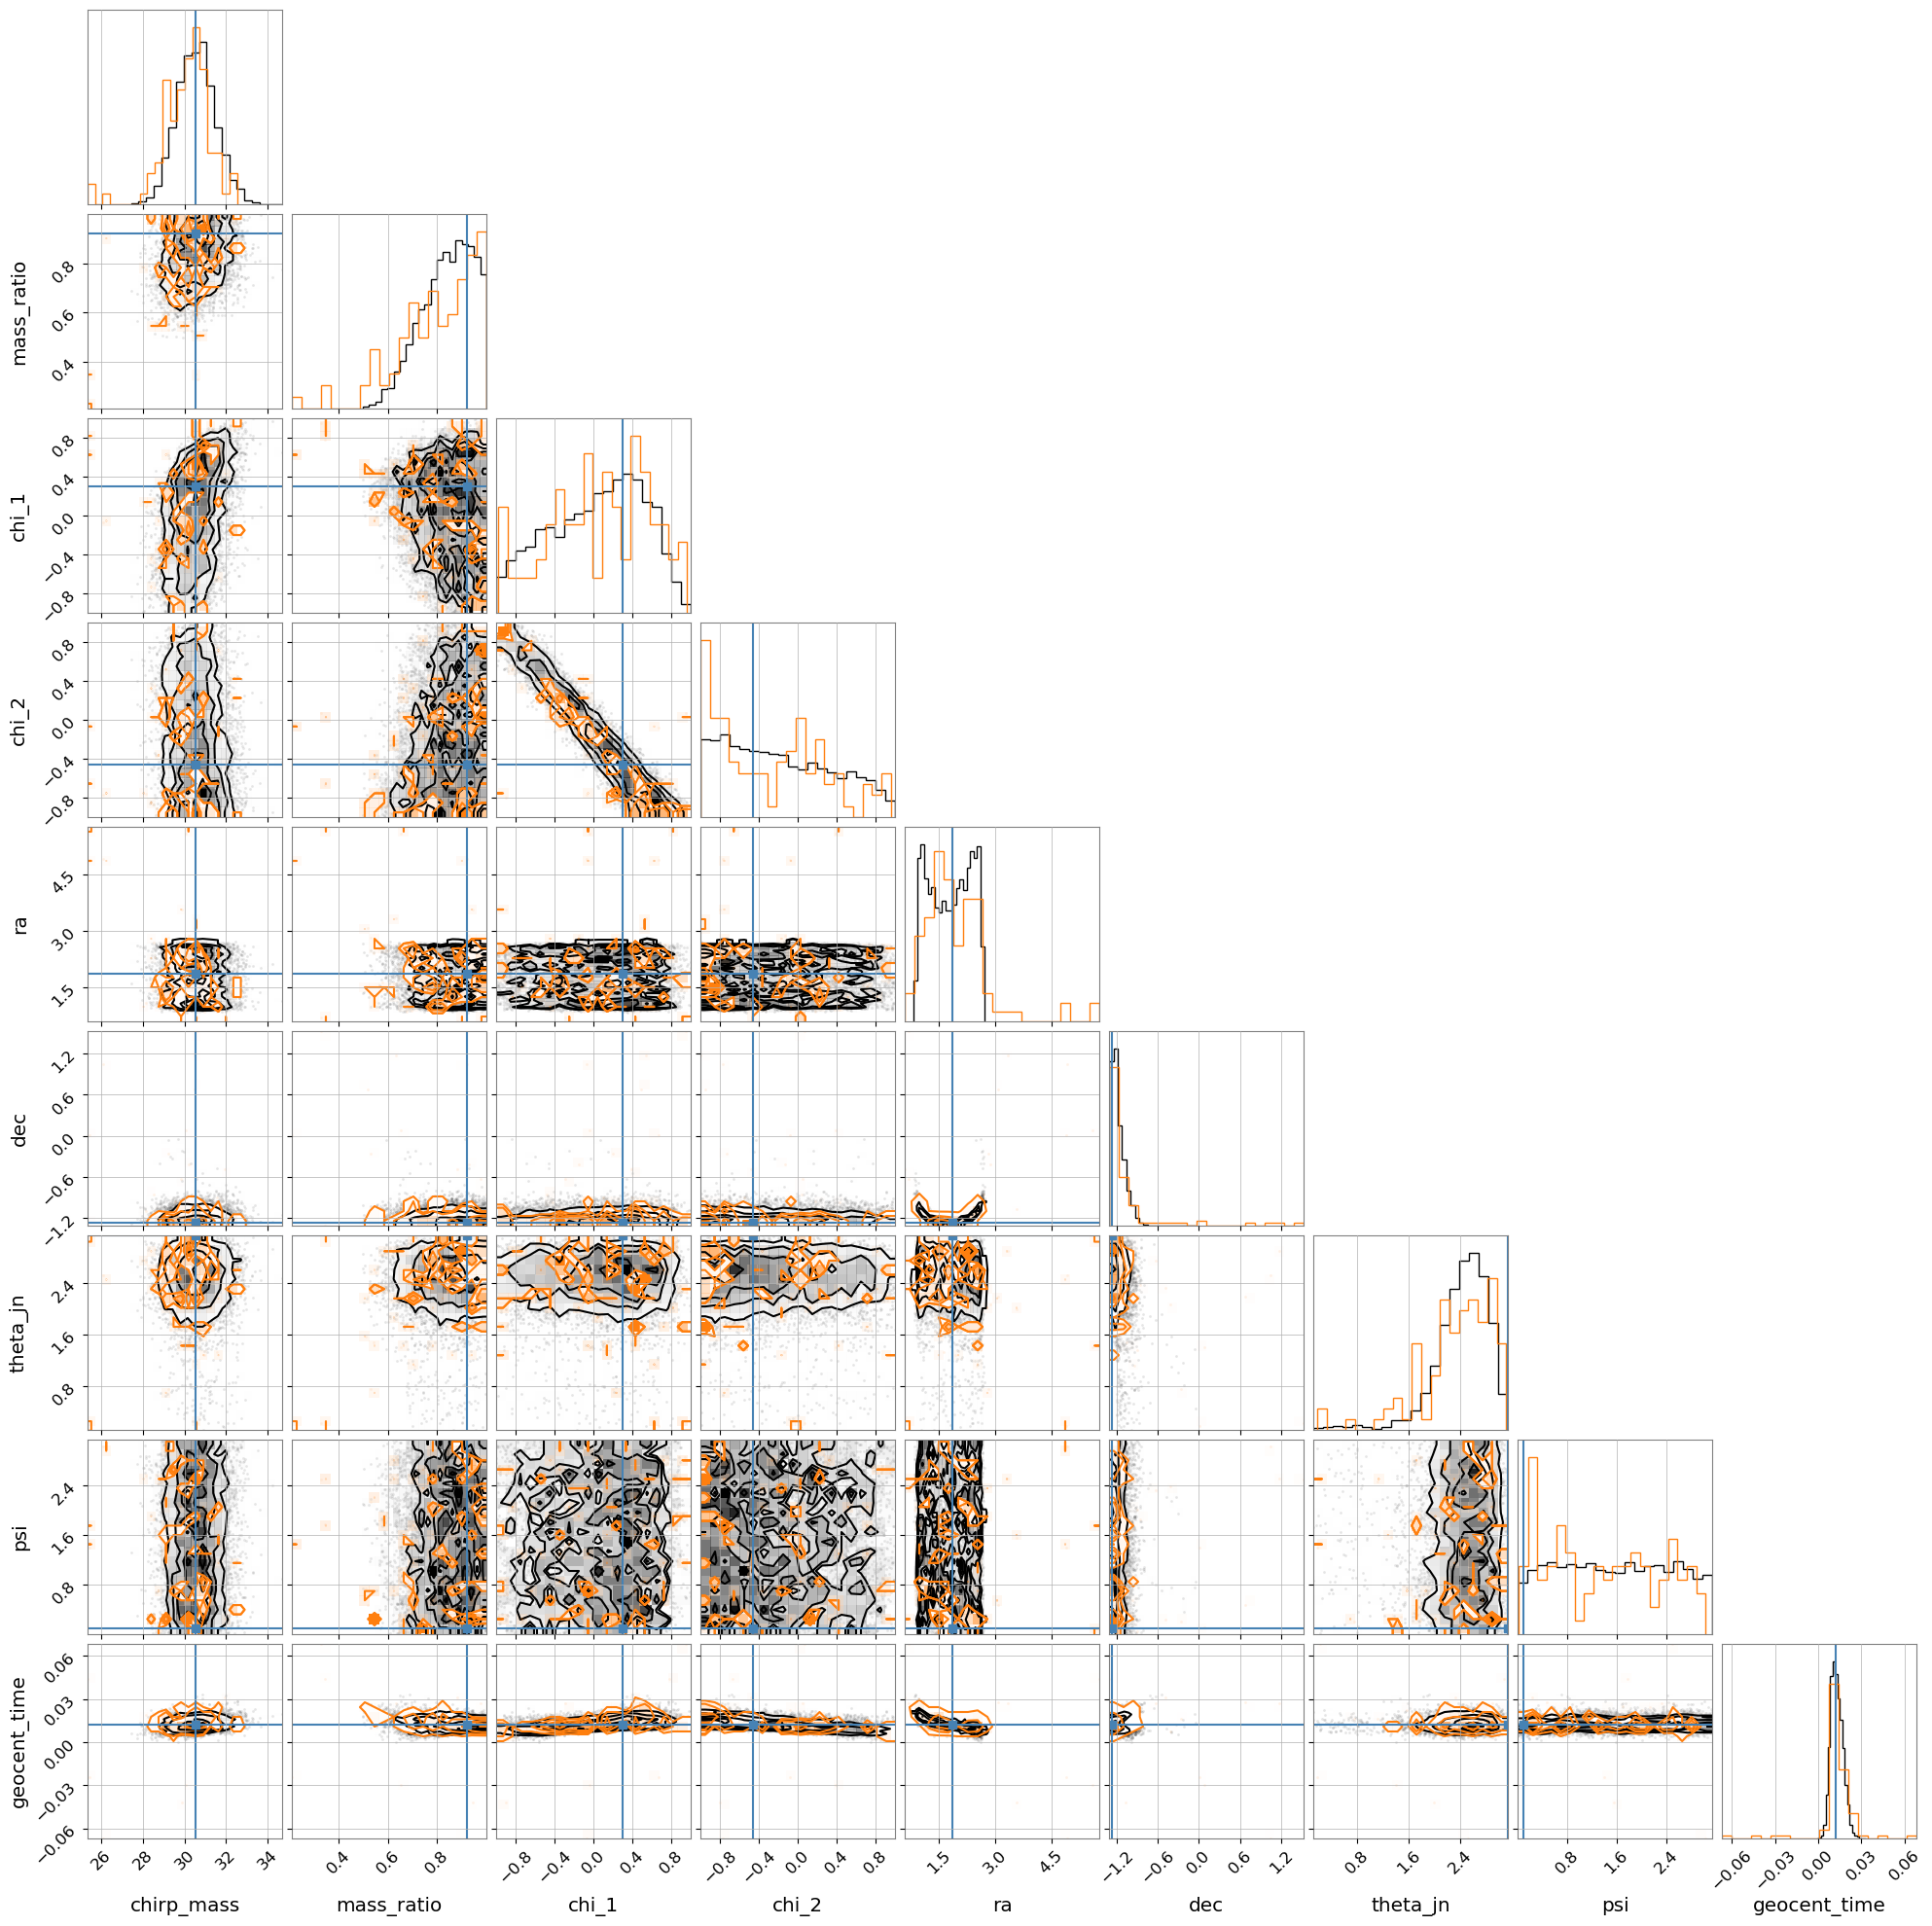

In [ ]:
fig = corner.corner(
    initial_samples,
    density=True,
    hist_kwargs={"density": True, "color": "k"},
)

fig = corner.corner(
    np.array(samples),
    plot_contour=False,
    plot_datapoints=True,
    labels=parameters,
    density=True,
    color="C1",
    hist_kwargs={"density": True, "color": "C1"},
    fig=fig,
    truths=min_result.x,
)

fig.savefig("GW150914_samples_300_samples.png", dpi=300)

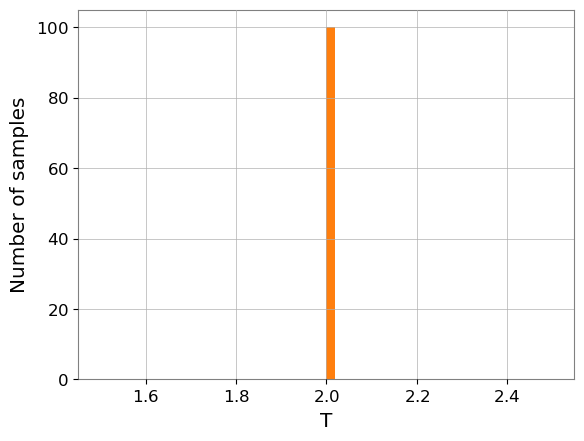

In [ ]:
fig = plt.figure()
plt.hist(t_vals, bins=50, density=False)
plt.xlabel("T")
plt.ylabel("Number of samples")
plt.show()

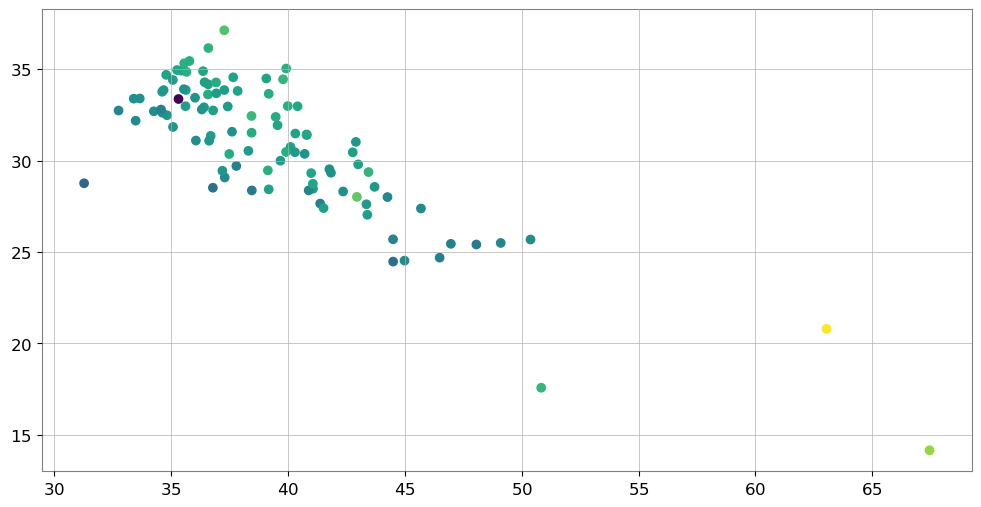

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
    samples[:, parameters.index("chirp_mass")],
    samples[:, parameters.index("mass_ratio")],
)
s1 = samples[:, parameters.index("chi_1")]
s2 = samples[:, parameters.index("chi_2")]
chi_eff = s1 + s2

axs.scatter(
    m1, m2, c=chi_eff
)
# Shade region m1 < m2